In [1]:
import CS_functions as cs
import numpy as np
from matplotlib import pyplot as plt
from scipy import fft as spfft
from scipy.constants import speed_of_light as C
plt.rcParams.update({'font.size':24, 'xtick.minor.visible': True, 'ytick.minor.visible': False,
                     'xtick.direction': 'in', 'ytick.direction': 'in', "xtick.top": True, "ytick.right": True,
                     'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4})

In [2]:
peak_freqs = np.array([182e9, 273e9])
envelope_FWHM = 30 #mm
FWHM_freq = 40e9 # 41.497e9 # Hz. (almost?) Equivelent to 30mm FWHM envelope 
total_points = 50
pixel_pitch= 1.0 # mm
theta= 6.1 # degrees
regularization_coeffient = 1e-2
test_config = np.array([13,17,19,25,29,34,35,45])


displacement = np.arange(-(total_points//2), (total_points+1)//2) *pixel_pitch #in mm
target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta)

uncertainties = np.ones_like(target)

reduced_points = len(test_config)

detectors, score = cs.douglas_peucker(reduced_points, target, uncertainties, regularization_coeffient)
print(*detectors, sep= ",")

25,22,38,26,40,17,10,49


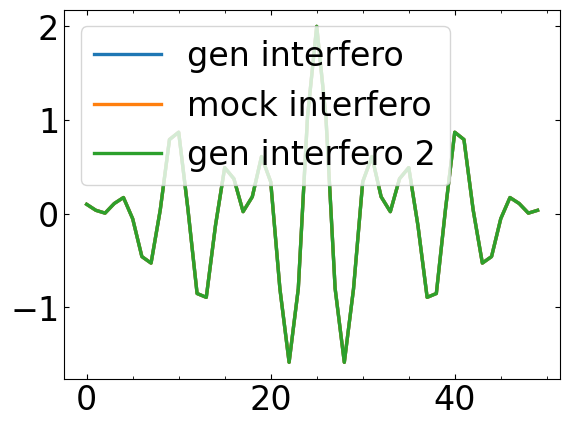

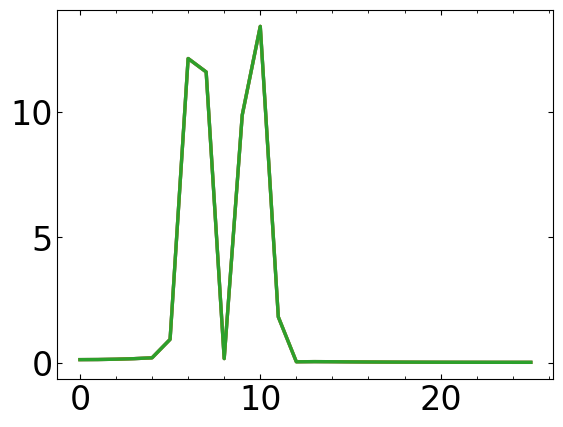

In [3]:
a, u = cs.open_dataset(r"1dmockanderrors33", ".csv")
b = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta)

plt.plot(target, label= "gen interfero")
plt.plot(a, label= "mock interfero")
plt.plot(b, label= "gen interfero 2")
plt.legend()
plt.show()

A = np.fft.rfft(a)
B = np.fft.rfft(b)
target_FFT = np.fft.rfft(target)

plt.plot(np.abs(target_FFT))
plt.plot(np.abs(A))
plt.plot(np.abs(B))
plt.show()

In [4]:
samples = np.full_like(target, np.nan)
samples[test_config] = target[test_config]
test_result = cs.compressed_sensing(samples, regularization_coeffient)

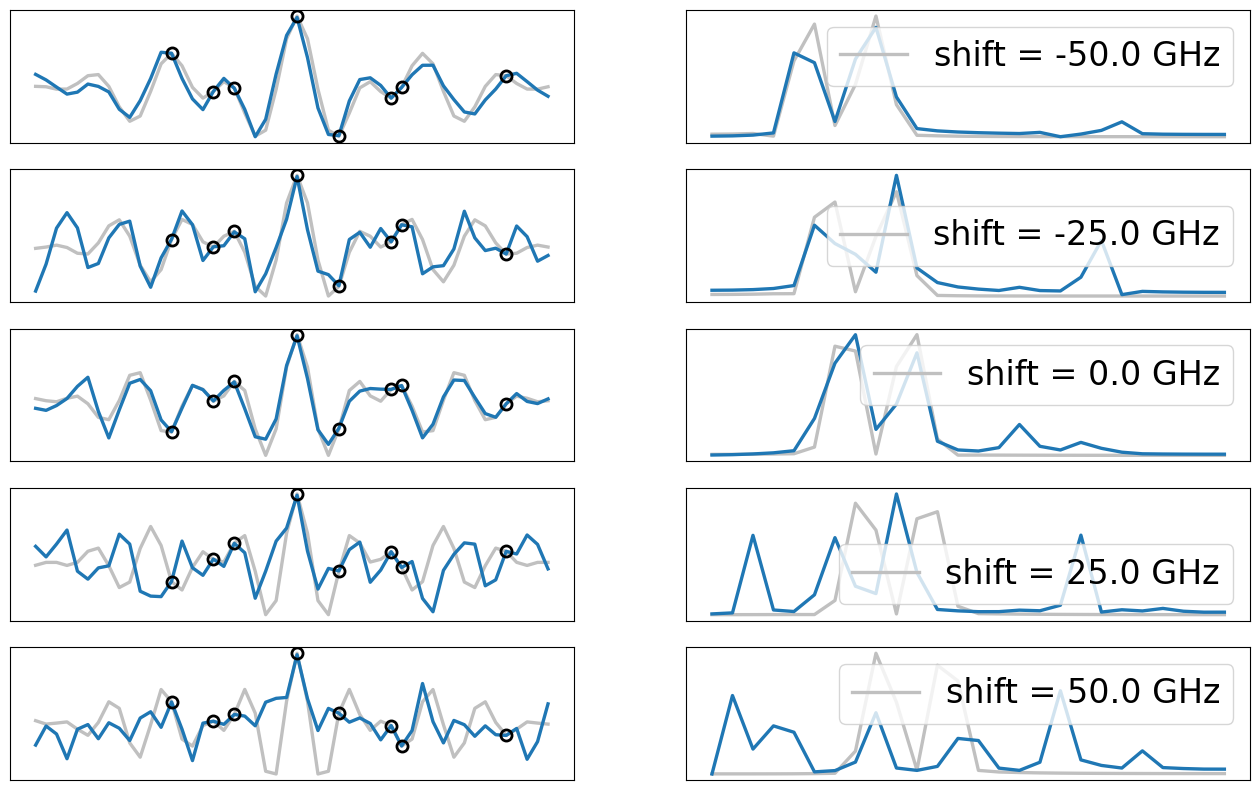

In [5]:
N = 5; shift_range= 50e9
shifts = np.linspace(-shift_range, shift_range, N)

fig, axs = plt.subplots(N, 2, figsize= (16, 2*N))

for ax, shift in zip(axs, shifts):

    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs +shift, envelope_FWHM*1e-3, theta)

    uncertainties = np.ones_like(target)

    samples = np.full_like(target, np.nan)
    samples[test_config] = target[test_config]
    test_result = cs.compressed_sensing(samples, regularization_coeffient)

    ax[0].plot(target, color= "silver", label= "actual signal")
    ax[0].plot(test_result, color= "tab:blue", label= "")
    ax[0].plot(test_config, target[test_config], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8, label= "samples")
    ax[0].set(xticks= [], yticks= [])

    target_FFT = np.fft.rfft(target)
    target_FFT = np.abs(target_FFT)
    reconstruction_FFT = np.fft.rfft(test_result)
    reconstruction_FFT = np.abs(reconstruction_FFT)

    ax[1].plot(target_FFT, color= "silver", label= f"shift = {shift*1e-9} GHz")
    ax[1].plot(reconstruction_FFT, color= "tab:blue")
    ax[1].set(xticks= [], yticks= [])
    ax[1].legend()

plt.show()

In [6]:
test_config

array([13, 17, 19, 25, 29, 34, 35, 45])

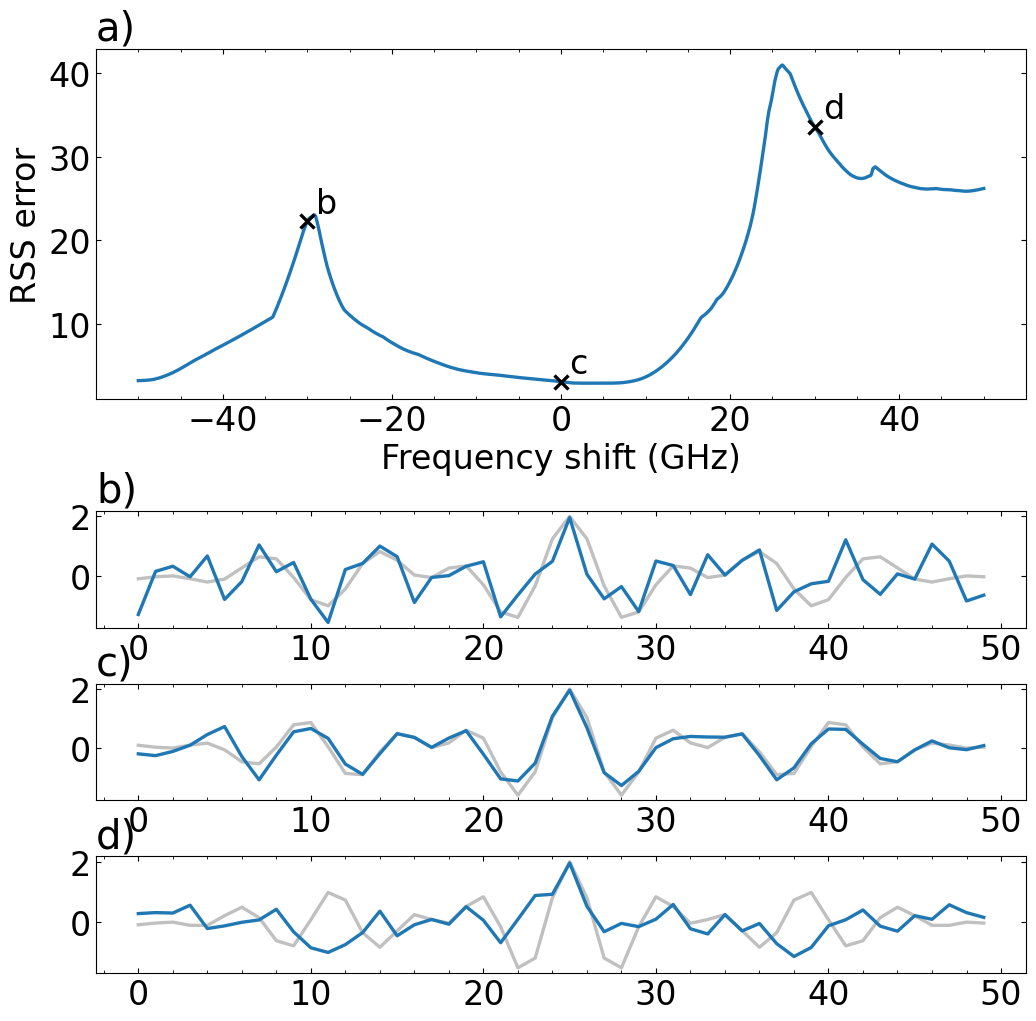

In [7]:
N = 1000; shift_range= 50e9
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs +shift, envelope_FWHM*1e-3, theta)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

examples = {}
examples["shift"] = [-30e9, 0, 30e9]
examples["target"] = [cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs +shift, envelope_FWHM*1e-3, theta) for shift in examples["shift"]]
examples["uncertainty"] = [np.ones_like(target) for target in examples["target"]]
examples["score"] = [cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient) for target, uncertainties in zip(examples["target"], examples["uncertainty"])]
examples["samples"] = [np.full_like(target, np.nan) for target in examples["target"]]
for samples, target in zip(examples["samples"], examples["target"]): samples[test_config] = target[test_config]
examples["reconstruction"] = [cs.compressed_sensing(samples, regularization_coeffient) for samples in examples["samples"]]

fig, axs = plt.subplots(5, 1, figsize= (12, 12), height_ratios= (3,0,1,1,1), gridspec_kw= {"hspace": 0.4})

axs[0].plot(shifts*1e-9, scores)
axs[0].set(xlabel= "Frequency shift (GHz)", ylabel= "RSS error")
axs[0].set_title("a)", loc='left')

axs[1].set_axis_off()

for ax, target, reconstruction, shift, score, title in zip(axs[2:], examples["target"], examples["reconstruction"], examples["shift"], examples["score"], ["b)","c)","d)"]):
    ax.plot(target, color= "silver")
    ax.plot(reconstruction)
    ax.set_title(title, loc= "left")
    axs[0].plot(shift*1e-9, score, marker= "x", color= "k")
    axs[0].text(shift*1e-9 +1, score +1, title.removesuffix(")"))

fig.savefig("./graphs/frequency_shift_robustness.png")
plt.show()


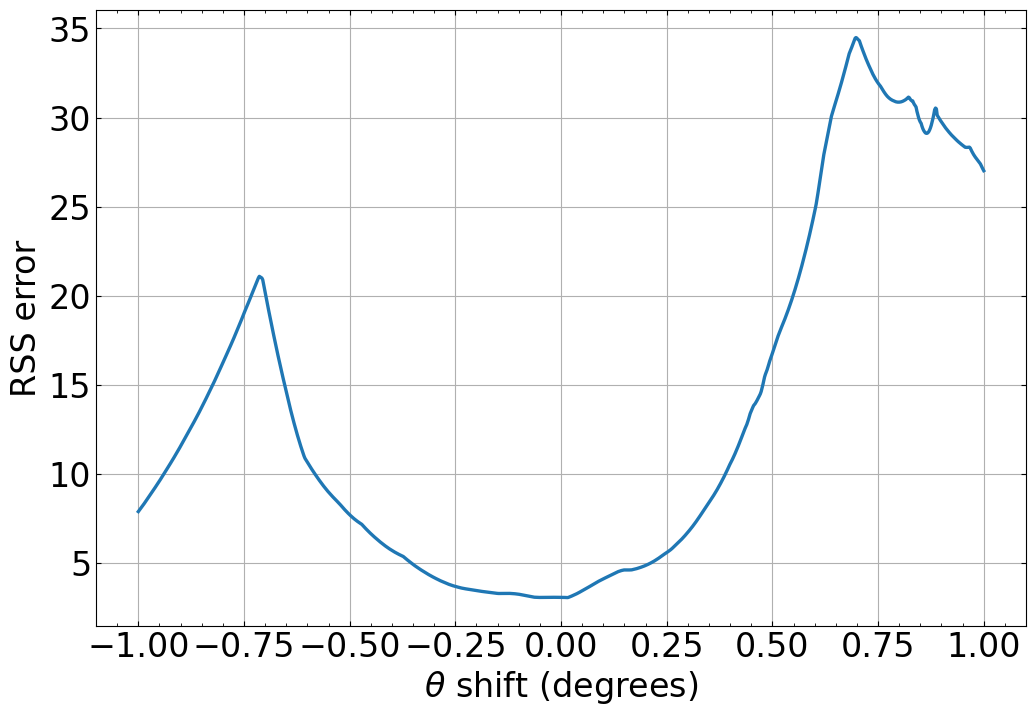

In [8]:
N = 1000; shift_range= 1.0
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta +shift)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts, scores)
axs.set(xlabel= r"$\theta$ shift (degrees)", ylabel= "RSS error")

plt.grid()
plt.show()


[0.72423338 0.15676726]


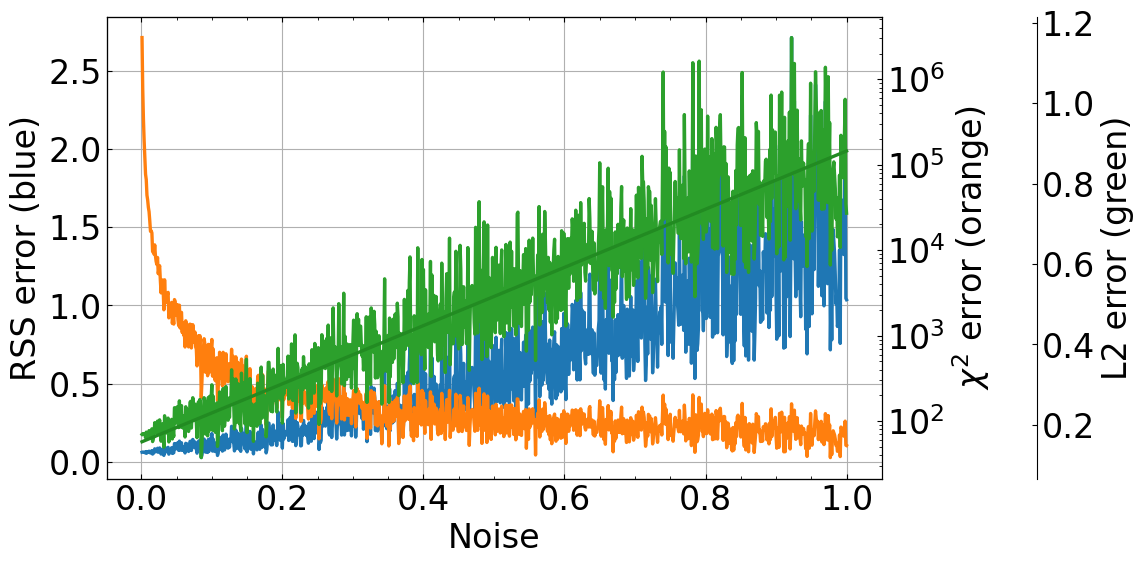

In [32]:
N = 1000; max_noise= 1.0
noises = np.linspace(1e-3, max_noise, N)
chisquared = np.empty(N)
RSS = np.empty(N)
L2 = np.empty(N)
signal_size = np.empty(N)

for n, noise in enumerate(noises):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta, noise)
    uncertainties = np.full_like(target, noise)

    chisquared[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)
    RSS[n] = cs.evaluate_score(test_config, target, np.ones_like(uncertainties), regularization_coeffient) /len(target)
    L2[n] = np.sqrt(cs.evaluate_score(test_config, target, np.ones_like(uncertainties), regularization_coeffient, domain= "DCT"))

fig, axs = plt.subplots(figsize= (10, 6))

axs.plot(noises, RSS)
axs.set(xlabel= "Noise", ylabel= "RSS error (blue)")

twinax = axs.twinx()
twinax.plot(noises, chisquared, color= "tab:orange")
twinax.set(ylabel= r"$\chi^2$ error (orange)", yscale= "log")

tripletax = axs.twinx()
tripletax.spines.right.set_position(("axes", 1.2))
tripletax.plot(noises, L2, color= "tab:green")
tripletax.set(ylabel= "L2 error (green)")
best_fit = np.polyfit(noises, L2, 1)
print(best_fit)
tripletax.plot(noises, best_fit[-2]*noises +best_fit[-1], color= "forestgreen")

axs.grid()
plt.show()

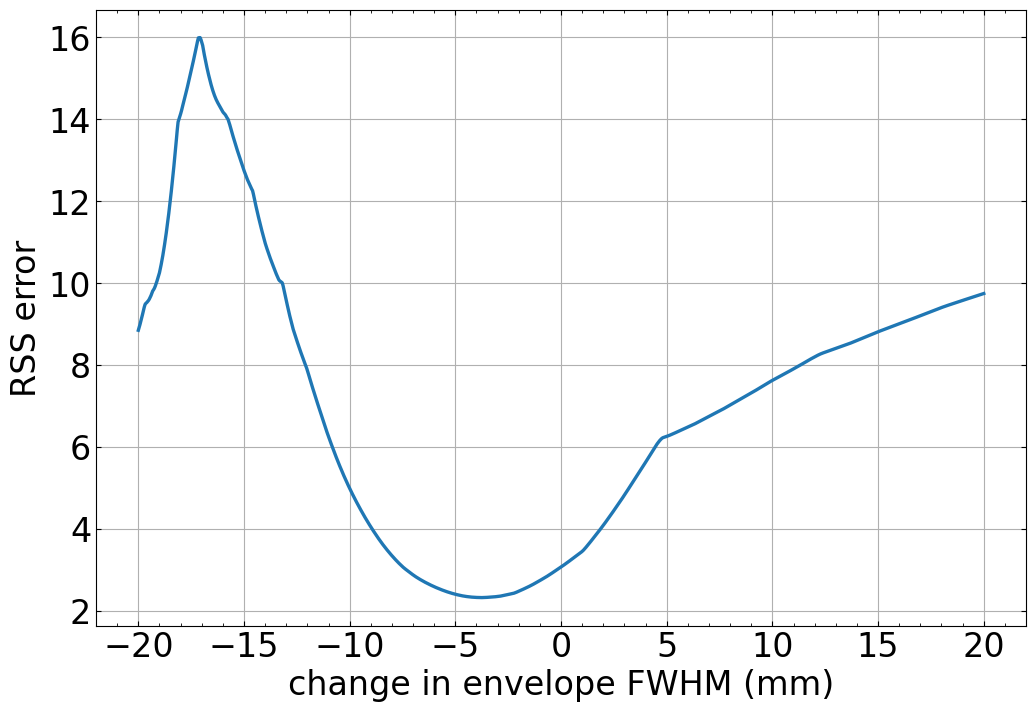

In [11]:
N = 1000; shift_range= 20
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, (envelope_FWHM +shift)*1e-3, theta)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts, scores)
axs.set(xlabel= r"change in envelope FWHM (mm)", ylabel= "RSS error")

plt.grid()
plt.show()

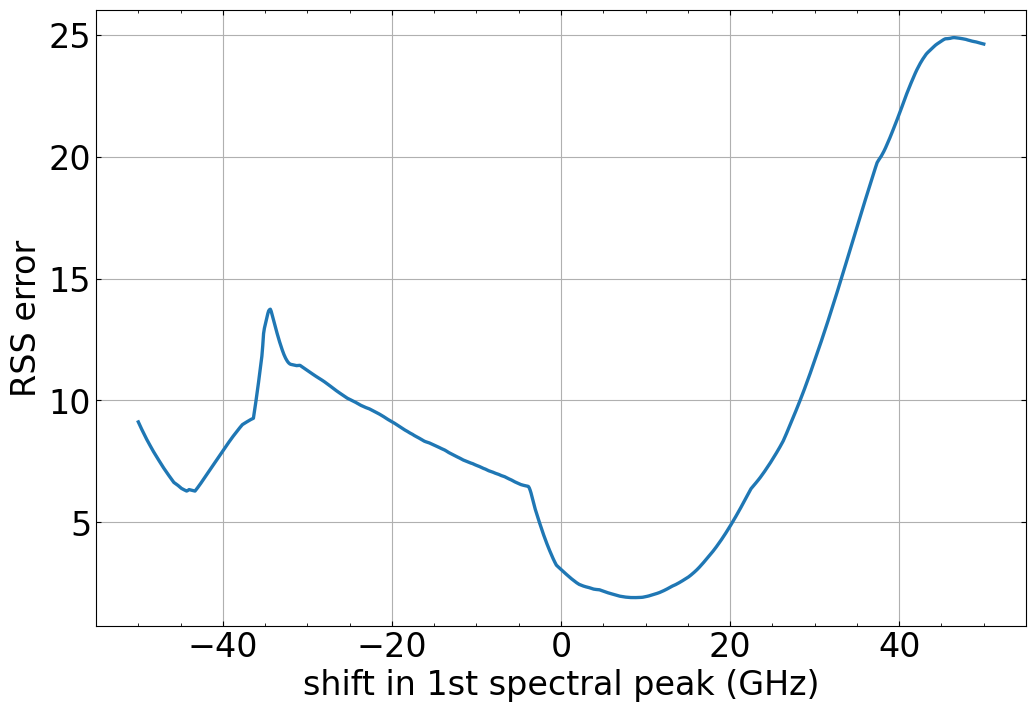

In [12]:
N = 1000; shift_range= 50e9
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, (peak_freqs[0]+shift, peak_freqs[1]), envelope_FWHM*1e-3, theta)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts*1e-9, scores)
axs.set(xlabel= "shift in 1st spectral peak (GHz)", ylabel= "RSS error")

plt.grid()
plt.show()

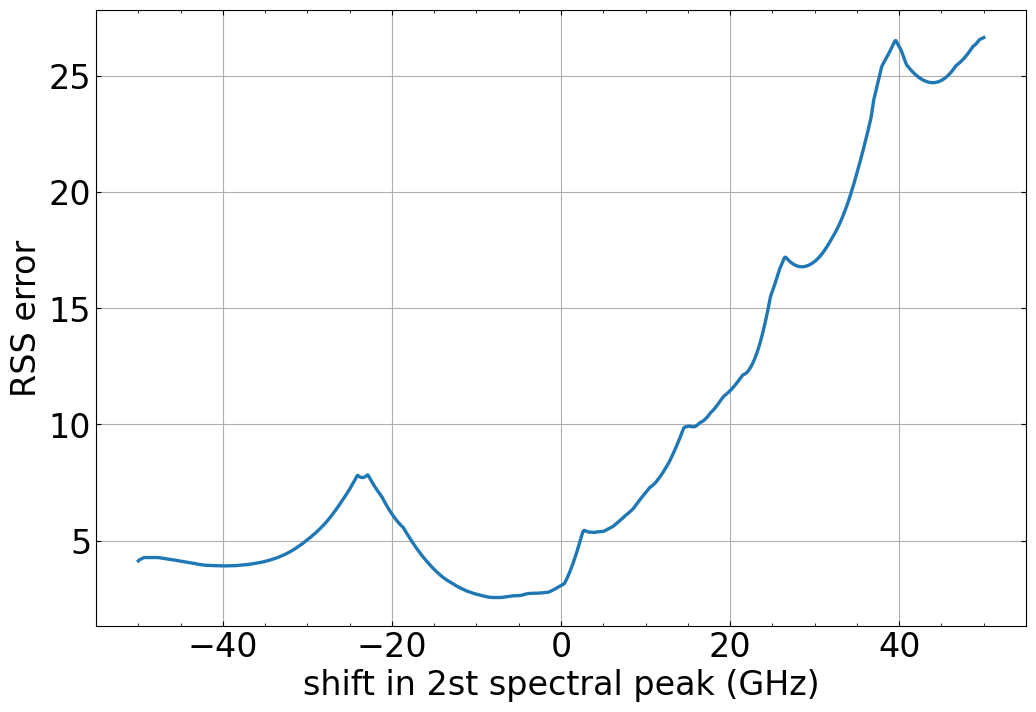

In [13]:
N = 1000; shift_range= 50e9
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, (peak_freqs[0], peak_freqs[1]+shift), envelope_FWHM*1e-3, theta)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts*1e-9, scores)
axs.set(xlabel= "shift in 2st spectral peak (GHz)", ylabel= "RSS error")

plt.grid()
plt.show()

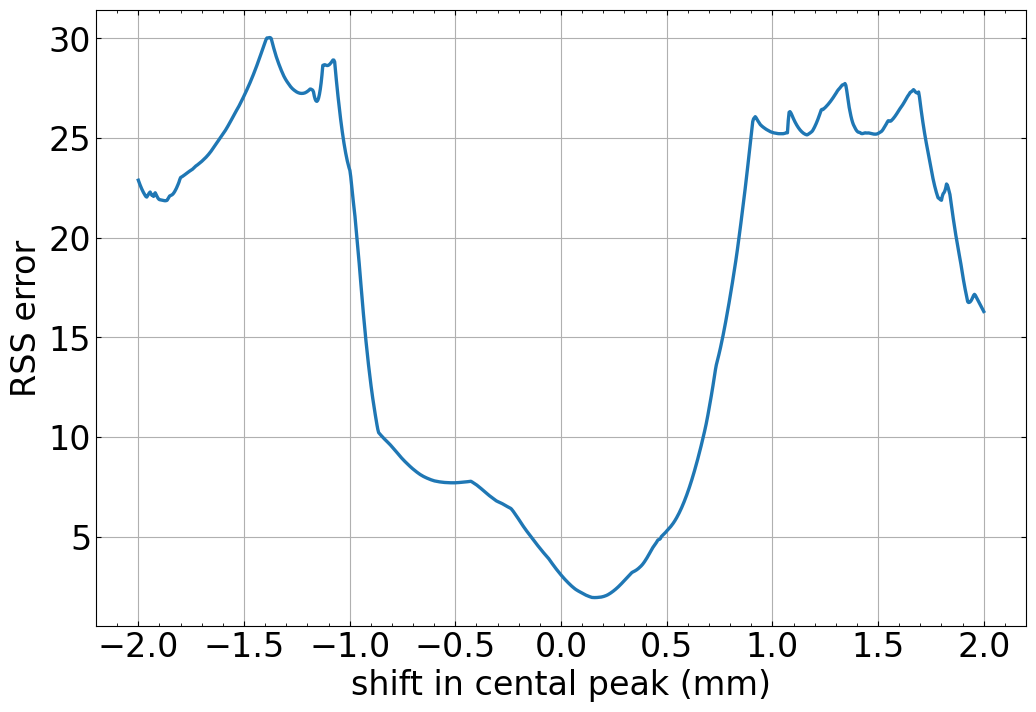

In [14]:
N = 1000; shift_range= 2
shifts = np.linspace(-shift_range, shift_range, N)
scores = np.empty(N)
RIPs = np.empty(N)
signal_size = np.empty(N)

for n, shift in enumerate(shifts):
    target = cs.generate_interferogram2(total_points, pixel_pitch*1e-3, peak_freqs, envelope_FWHM*1e-3, theta, displacement_shift= shift*1e-3)
    uncertainties = np.ones_like(target)

    scores[n] = cs.evaluate_score(test_config, target, uncertainties, regularization_coeffient)

fig, axs = plt.subplots(figsize= (12, 8))

axs.plot(shifts, scores)
axs.set(xlabel= "shift in cental peak (mm)", ylabel= "RSS error")

plt.grid()
plt.show()